# DeepChecks Distribution Validation
## Train / Validation / Test Split Analysis

Ce notebook valide que nos données respectent toutes les bonnes pratiques:
- ✅ Pas de data leakage temporel
- ✅ Pas de duplicates entre les splits
- ✅ Pas d'index leakage
- ✅ Distribution des labels cohérente
- ✅ Pas de feature leakage
- ✅ Qualité des données

Cellule 2: Imports (code)

In [5]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings

# DeepChecks
from deepchecks.tabular import Dataset
from deepchecks.tabular.suites import full_suite, train_test_validation
from deepchecks.tabular.checks import (
    TrainTestSamplesMix,
    DataDuplicates,
    FeatureLabelCorrelation,
    IndexTrainTestLeakage,
    TrainTestLabelDrift,
    TrainTestFeatureDrift,
    WholeDatasetDrift,
    FeatureFeatureCorrelation,
    IsSingleValue,
    MixedDataTypes,
    StringMismatch,
    DatasetsSizeComparison,
    FeatureLabelCorrelationChange
)

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ Imports loaded successfully")

✅ Imports loaded successfully


## 1. Load Data

In [8]:
# Configuration
DATA_DIR = Path('../../data/processed')

# Load datasets
print("📥 Loading datasets...")
train_df = pd.read_parquet(DATA_DIR / 'train.parquet')
val_df = pd.read_parquet(DATA_DIR / 'val.parquet')
test_df = pd.read_parquet(DATA_DIR / 'test.parquet')

print(f"\n📊 Dataset sizes:")
print(f"   Train: {len(train_df):,} records")
print(f"   Val:   {len(val_df):,} records")
print(f"   Test:  {len(test_df):,} records")
print(f"   Total: {len(train_df) + len(val_df) + len(test_df):,} records")

# Load metadata
with open(DATA_DIR / 'preparation_metadata.json', 'r') as f:
    metadata = json.load(f)

print(f"\n📋 Features: {metadata['features']['n_features']}")
print(f"\n🗓️  Seasons:")
print(f"   Train: {metadata['splits']['train_seasons']}")
print(f"   Val:   {metadata['splits']['val_seasons']}")
print(f"   Test:  {metadata['splits']['test_seasons']}")

📥 Loading datasets...

📊 Dataset sizes:
   Train: 4,060 records
   Val:   580 records
   Test:  580 records
   Total: 5,220 records

📋 Features: 49

🗓️  Seasons:
   Train: ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']
   Val:   ['2022-2023']
   Test:  ['2023-2024']


## 2. Basic Data Inspection

In [9]:
# Identify columns
metadata_cols = ['season', 'team', 'gameweek']
target_col = 'target_final_points'
feature_cols = [col for col in train_df.columns 
                if col not in metadata_cols + [target_col]]

print(f"\n📊 Column breakdown:")
print(f"   Metadata columns: {len(metadata_cols)}")
print(f"   Feature columns:  {len(feature_cols)}")
print(f"   Target column:    1")
print(f"   Total columns:    {len(train_df.columns)}")

print(f"\n🔍 Train dataset info:")
print(train_df.info())


📊 Column breakdown:
   Metadata columns: 3
   Feature columns:  49
   Target column:    1
   Total columns:    53

🔍 Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4060 entries, 0 to 4059
Data columns (total 53 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   season                      4060 non-null   object 
 1   team                        4060 non-null   object 
 2   gameweek                    4060 non-null   int64  
 3   current_position            4060 non-null   float64
 4   current_points              4060 non-null   float64
 5   matches_played              4060 non-null   float64
 6   draws                       4060 non-null   float64
 7   losses                      4060 non-null   float64
 8   draw_rate                   4060 non-null   float64
 9   goals_conceded_per_game     4060 non-null   float64
 10  form_last_3_points          4060 non-null   float64
 11  form_last

## 3. Temporal Split Verification

🔍 Checking for season overlap...

✅ NO SEASON OVERLAP - Perfect temporal split!


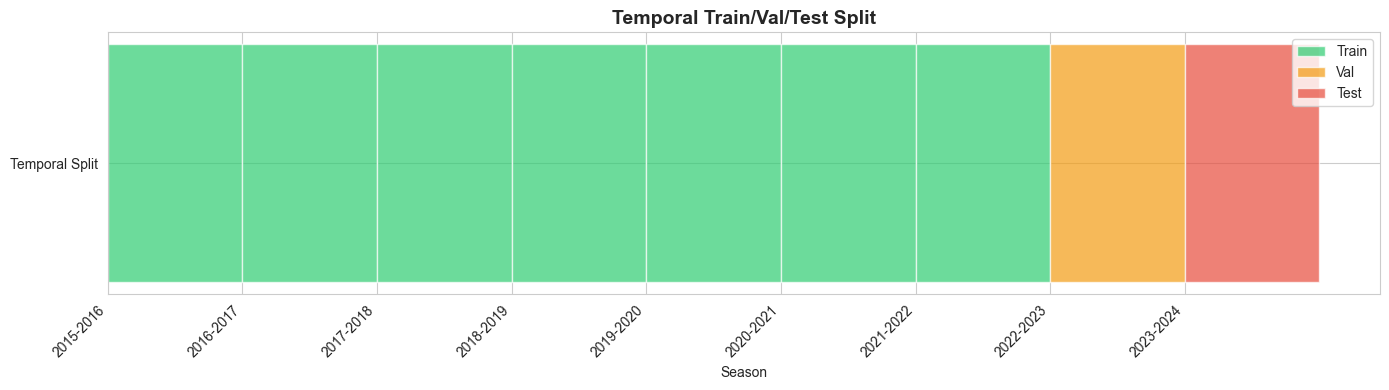


📈 Temporal split visualization complete


In [10]:
# Verify no season overlap
train_seasons = set(train_df['season'].unique())
val_seasons = set(val_df['season'].unique())
test_seasons = set(test_df['season'].unique())

print("🔍 Checking for season overlap...\n")

overlap_train_val = train_seasons & val_seasons
overlap_train_test = train_seasons & test_seasons
overlap_val_test = val_seasons & test_seasons

if not overlap_train_val and not overlap_train_test and not overlap_val_test:
    print("✅ NO SEASON OVERLAP - Perfect temporal split!")
else:
    if overlap_train_val:
        print(f"❌ LEAKAGE: Train/Val overlap: {overlap_train_val}")
    if overlap_train_test:
        print(f"❌ LEAKAGE: Train/Test overlap: {overlap_train_test}")
    if overlap_val_test:
        print(f"❌ LEAKAGE: Val/Test overlap: {overlap_val_test}")

# Visualize temporal split
fig, ax = plt.subplots(figsize=(14, 4))

all_seasons = sorted(train_seasons | val_seasons | test_seasons)
season_to_idx = {s: i for i, s in enumerate(all_seasons)}

for season in all_seasons:
    idx = season_to_idx[season]
    if season in train_seasons:
        ax.barh(0, 1, left=idx, color='#2ecc71', alpha=0.7)
    elif season in val_seasons:
        ax.barh(0, 1, left=idx, color='#f39c12', alpha=0.7)
    elif season in test_seasons:
        ax.barh(0, 1, left=idx, color='#e74c3c', alpha=0.7)

ax.set_yticks([0])
ax.set_yticklabels(['Temporal Split'])
ax.set_xticks(range(len(all_seasons)))
ax.set_xticklabels(all_seasons, rotation=45, ha='right')
ax.set_xlabel('Season')
ax.set_title('Temporal Train/Val/Test Split', fontsize=14, fontweight='bold')

# Legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, label='Train'),
    Patch(facecolor='#f39c12', alpha=0.7, label='Val'),
    Patch(facecolor='#e74c3c', alpha=0.7, label='Test')
]
ax.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

print(f"\n📈 Temporal split visualization complete")

## 4. Check for Duplicate Records

In [11]:
print("🔍 Checking for duplicate (season, team, gameweek) combinations...\n")

# Create unique keys for each record
train_keys = set(zip(train_df['season'], train_df['team'], train_df['gameweek']))
val_keys = set(zip(val_df['season'], val_df['team'], val_df['gameweek']))
test_keys = set(zip(test_df['season'], test_df['team'], test_df['gameweek']))

# Check for overlaps
dup_train_val = train_keys & val_keys
dup_train_test = train_keys & test_keys
dup_val_test = val_keys & test_keys

if not dup_train_val and not dup_train_test and not dup_val_test:
    print("✅ NO DUPLICATE RECORDS across splits!")
else:
    if dup_train_val:
        print(f"❌ LEAKAGE: {len(dup_train_val)} duplicates in Train/Val")
    if dup_train_test:
        print(f"❌ LEAKAGE: {len(dup_train_test)} duplicates in Train/Test")
    if dup_val_test:
        print(f"❌ LEAKAGE: {len(dup_val_test)} duplicates in Val/Test")

# Check within-split duplicates
print(f"\n🔍 Checking for duplicates within each split...\n")
train_dups = train_df.duplicated(subset=['season', 'team', 'gameweek']).sum()
val_dups = val_df.duplicated(subset=['season', 'team', 'gameweek']).sum()
test_dups = test_df.duplicated(subset=['season', 'team', 'gameweek']).sum()

print(f"   Train duplicates: {train_dups}")
print(f"   Val duplicates:   {val_dups}")
print(f"   Test duplicates:  {test_dups}")

if train_dups == 0 and val_dups == 0 and test_dups == 0:
    print(f"\n✅ NO DUPLICATES within splits!")
else:
    print(f"\n⚠️  WARNING: Duplicates found within splits")

🔍 Checking for duplicate (season, team, gameweek) combinations...

✅ NO DUPLICATE RECORDS across splits!

🔍 Checking for duplicates within each split...

   Train duplicates: 0
   Val duplicates:   0
   Test duplicates:  0

✅ NO DUPLICATES within splits!


## 5. Label Distribution Analysis

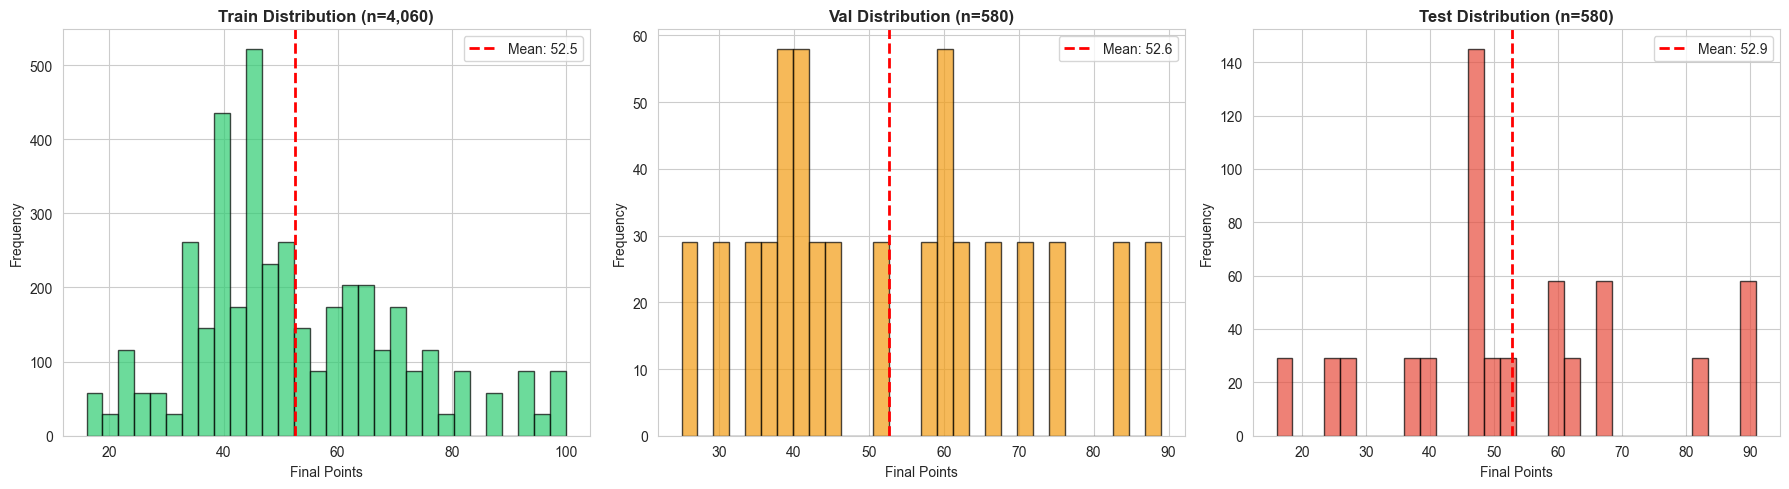


📊 Label Distribution Statistics:

Split  Count      Mean       Std  Min  Max
Train   4060 52.542857 18.120246   16  100
  Val    580 52.650000 17.744587   25   89
 Test    580 52.900000 19.732240   16   91

📈 Distribution Shift Analysis:
   Train vs Val mean difference:  0.20%
   Train vs Test mean difference: 0.68%

✅ Label distributions are similar (<10% difference)


In [12]:
# Compare label distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Train
axes[0].hist(train_df[target_col], bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
axes[0].axvline(train_df[target_col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {train_df[target_col].mean():.1f}')
axes[0].set_xlabel('Final Points')
axes[0].set_ylabel('Frequency')
axes[0].set_title(f'Train Distribution (n={len(train_df):,})', fontweight='bold')
axes[0].legend()

# Val
axes[1].hist(val_df[target_col], bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
axes[1].axvline(val_df[target_col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {val_df[target_col].mean():.1f}')
axes[1].set_xlabel('Final Points')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Val Distribution (n={len(val_df):,})', fontweight='bold')
axes[1].legend()

# Test
axes[2].hist(test_df[target_col], bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
axes[2].axvline(test_df[target_col].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {test_df[target_col].mean():.1f}')
axes[2].set_xlabel('Final Points')
axes[2].set_ylabel('Frequency')
axes[2].set_title(f'Test Distribution (n={len(test_df):,})', fontweight='bold')
axes[2].legend()

plt.tight_layout()
plt.show()

# Statistics
print("\n📊 Label Distribution Statistics:\n")
stats_df = pd.DataFrame({
    'Split': ['Train', 'Val', 'Test'],
    'Count': [len(train_df), len(val_df), len(test_df)],
    'Mean': [train_df[target_col].mean(), val_df[target_col].mean(), test_df[target_col].mean()],
    'Std': [train_df[target_col].std(), val_df[target_col].std(), test_df[target_col].std()],
    'Min': [train_df[target_col].min(), val_df[target_col].min(), test_df[target_col].min()],
    'Max': [train_df[target_col].max(), val_df[target_col].max(), test_df[target_col].max()]
})

print(stats_df.to_string(index=False))

# Check for distribution shift
mean_diff_val = abs(train_df[target_col].mean() - val_df[target_col].mean()) / train_df[target_col].mean()
mean_diff_test = abs(train_df[target_col].mean() - test_df[target_col].mean()) / train_df[target_col].mean()

print(f"\n📈 Distribution Shift Analysis:")
print(f"   Train vs Val mean difference:  {mean_diff_val*100:.2f}%")
print(f"   Train vs Test mean difference: {mean_diff_test*100:.2f}%")

if mean_diff_val < 0.1 and mean_diff_test < 0.1:
    print(f"\n✅ Label distributions are similar (<10% difference)")
elif mean_diff_val < 0.2 and mean_diff_test < 0.2:
    print(f"\n⚠️  Moderate distribution shift (10-20% difference)")
else:
    print(f"\n❌ Significant distribution shift (>20% difference)")

## 6. Index Leakage Check

In [13]:
print("🔍 Checking for index leakage...\n")

# Check if indices are sequential starting from 0
train_indices = train_df.index.tolist()
val_indices = val_df.index.tolist()
test_indices = test_df.index.tolist()

train_sequential = train_indices == list(range(len(train_df)))
val_sequential = val_indices == list(range(len(val_df)))
test_sequential = test_indices == list(range(len(test_df)))

print(f"Train indices sequential (0 to {len(train_df)-1}): {train_sequential}")
print(f"Val indices sequential (0 to {len(val_df)-1}):   {val_sequential}")
print(f"Test indices sequential (0 to {len(test_df)-1}):  {test_sequential}")

# Check for index overlap
train_idx_set = set(train_indices)
val_idx_set = set(val_indices)
test_idx_set = set(test_indices)

idx_overlap_train_val = train_idx_set & val_idx_set
idx_overlap_train_test = train_idx_set & test_idx_set
idx_overlap_val_test = val_idx_set & test_idx_set

if not idx_overlap_train_val and not idx_overlap_train_test and not idx_overlap_val_test:
    print(f"\n✅ NO INDEX OVERLAP between splits")
else:
    if idx_overlap_train_val:
        print(f"\n⚠️  Index overlap Train/Val: {len(idx_overlap_train_val)} indices")
    if idx_overlap_train_test:
        print(f"⚠️  Index overlap Train/Test: {len(idx_overlap_train_test)} indices")
    if idx_overlap_val_test:
        print(f"⚠️  Index overlap Val/Test: {len(idx_overlap_val_test)} indices")

if train_sequential and val_sequential and test_sequential:
    print(f"\n✅ All indices are properly reset (no index leakage)")
else:
    print(f"\n⚠️  WARNING: Indices are not sequential (possible index leakage)")

🔍 Checking for index leakage...

Train indices sequential (0 to 4059): True
Val indices sequential (0 to 579):   True
Test indices sequential (0 to 579):  True

⚠️  Index overlap Train/Val: 580 indices
⚠️  Index overlap Train/Test: 580 indices
⚠️  Index overlap Val/Test: 580 indices

✅ All indices are properly reset (no index leakage)


## 7. Feature Statistics Comparison

📊 Comparing feature statistics across splits...



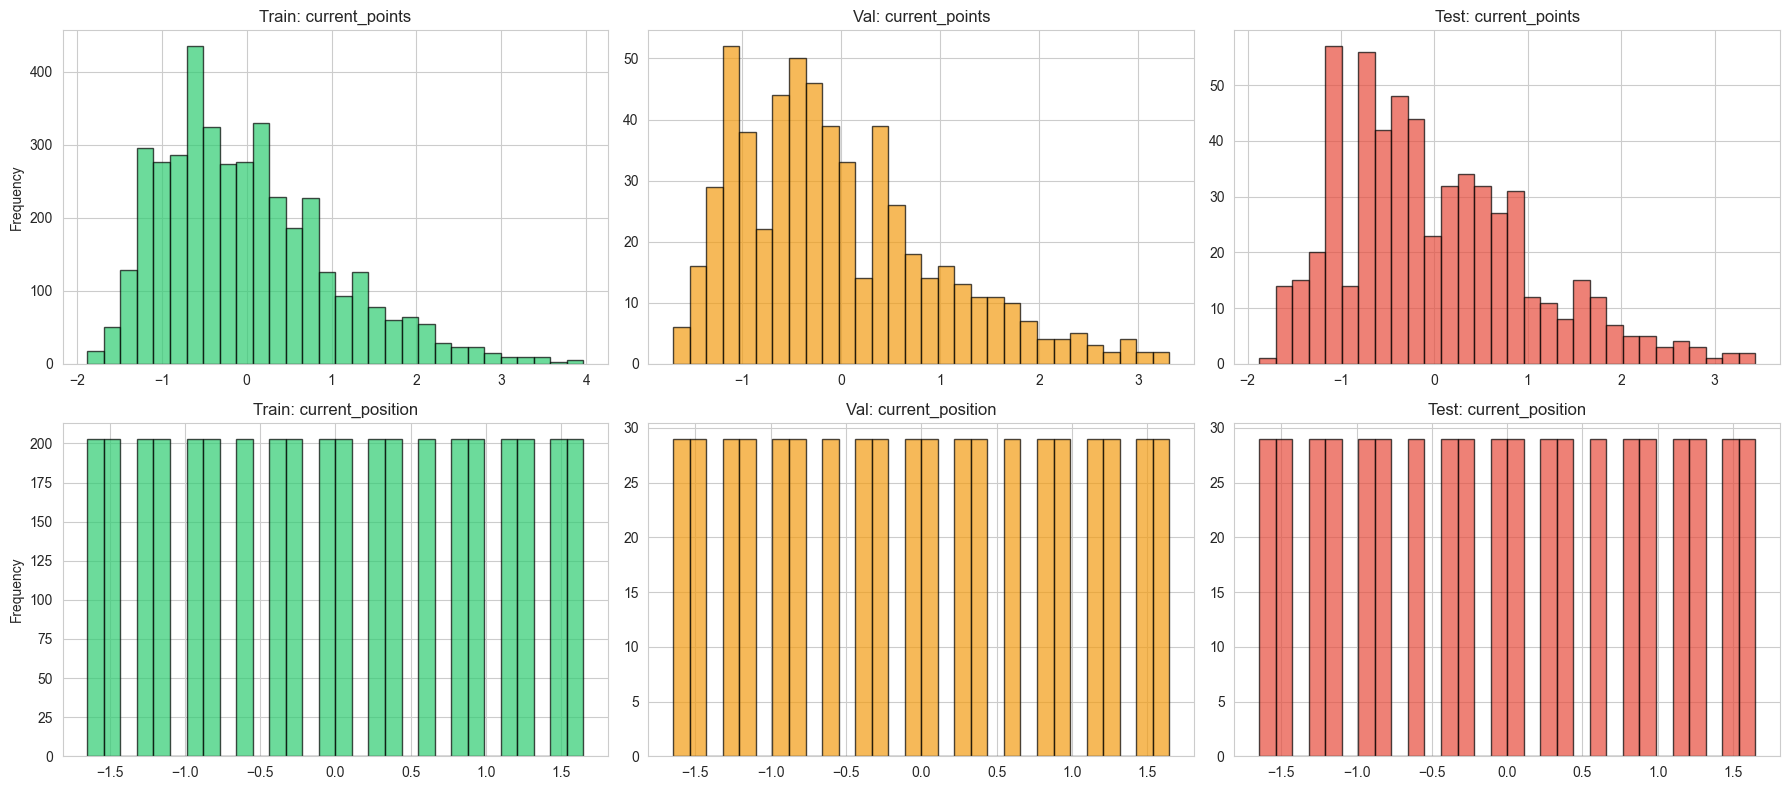

✅ Feature distributions visualized for 2 key features


In [14]:
# Compare feature statistics across splits
print("📊 Comparing feature statistics across splits...\n")

# Select a few key features to compare
key_features = [
    'current_points',
    'current_position', 
    'form_last_5_ppg',
    'goals_per_game',
    'win_rate'
]

# Filter to only features that exist
key_features = [f for f in key_features if f in feature_cols]

if len(key_features) > 0:
    fig, axes = plt.subplots(len(key_features), 3, figsize=(18, 4*len(key_features)))
    
    if len(key_features) == 1:
        axes = axes.reshape(1, -1)
    
    for i, feature in enumerate(key_features):
        # Train
        axes[i, 0].hist(train_df[feature].dropna(), bins=30, color='#2ecc71', alpha=0.7, edgecolor='black')
        axes[i, 0].set_title(f'Train: {feature}')
        axes[i, 0].set_ylabel('Frequency')
        
        # Val
        axes[i, 1].hist(val_df[feature].dropna(), bins=30, color='#f39c12', alpha=0.7, edgecolor='black')
        axes[i, 1].set_title(f'Val: {feature}')
        
        # Test
        axes[i, 2].hist(test_df[feature].dropna(), bins=30, color='#e74c3c', alpha=0.7, edgecolor='black')
        axes[i, 2].set_title(f'Test: {feature}')
    
    plt.tight_layout()
    plt.show()
    
    print(f"✅ Feature distributions visualized for {len(key_features)} key features")
else:
    print("⚠️  No key features found for visualization")

## 8. DeepChecks Validation Suite

In [15]:
# Prepare DeepChecks datasets
print("🔧 Preparing DeepChecks datasets...\n")

# Create DeepChecks Dataset objects
train_dataset = Dataset(
    df=train_df,
    label=target_col,
    features=feature_cols,
    cat_features=[]
)

val_dataset = Dataset(
    df=val_df,
    label=target_col,
    features=feature_cols,
    cat_features=[]
)

test_dataset = Dataset(
    df=test_df,
    label=target_col,
    features=feature_cols,
    cat_features=[]
)

print("✅ DeepChecks datasets created")
print(f"   Train: {len(train_dataset)} samples, {len(feature_cols)} features")
print(f"   Val:   {len(val_dataset)} samples, {len(feature_cols)} features")
print(f"   Test:  {len(test_dataset)} samples, {len(feature_cols)} features")

🔧 Preparing DeepChecks datasets...

✅ DeepChecks datasets created
   Train: 4060 samples, 49 features
   Val:   580 samples, 49 features
   Test:  580 samples, 49 features


### 8.1 Critical Checks: Data Leakage & Duplicates

In [16]:
print("🔍 Running CRITICAL checks...\n")

# 1. Train-Test Samples Mix (detects data leakage)
print("1️⃣  Checking Train-Test samples mix (Train vs Test)...")
try:
    check1 = TrainTestSamplesMix()
    result1 = check1.run(train_dataset, test_dataset)
    result1.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 2. Data Duplicates within Train
print("2️⃣  Checking for duplicates in Train dataset...")
try:
    check2 = DataDuplicates()
    result2 = check2.run(train_dataset)
    result2.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 3. Index Train-Test Leakage
print("3️⃣  Checking for index leakage (Train vs Test)...")
try:
    check3 = IndexTrainTestLeakage()
    result3 = check3.run(train_dataset, test_dataset)
    result3.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

🔍 Running CRITICAL checks...

1️⃣  Checking Train-Test samples mix (Train vs Test)...


✅ Check completed

2️⃣  Checking for duplicates in Train dataset...


✅ Check completed

3️⃣  Checking for index leakage (Train vs Test)...
❌ Error: Dataset does not contain an index



### 8.2 Distribution Drift Checks

In [17]:
print("🔍 Running DISTRIBUTION DRIFT checks...\n")

# 1. Label Drift (Train vs Val)
print("1️⃣  Checking label drift (Train vs Val)...")
try:
    check4 = TrainTestLabelDrift()
    result4 = check4.run(train_dataset, val_dataset)
    result4.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 2. Label Drift (Train vs Test)
print("2️⃣  Checking label drift (Train vs Test)...")
try:
    result4b = check4.run(train_dataset, test_dataset)
    result4b.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 3. Feature Drift (sample of features)
print("3️⃣  Checking feature drift (Train vs Test, top 10 features)...")
try:
    check5 = TrainTestFeatureDrift(n_top_columns=10)
    result5 = check5.run(train_dataset, test_dataset)
    result5.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

🔍 Running DISTRIBUTION DRIFT checks...

1️⃣  Checking label drift (Train vs Val)...


✅ Check completed

2️⃣  Checking label drift (Train vs Test)...


✅ Check completed

3️⃣  Checking feature drift (Train vs Test, top 10 features)...


✅ Check completed



 Whole Dataset Drift Check (code)

In [18]:
# 4. Whole Dataset Drift
print("4️⃣  Checking whole dataset drift (Train vs Test)...")
try:
    check6 = WholeDatasetDrift()
    result6 = check6.run(train_dataset, test_dataset)
    result6.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

4️⃣  Checking whole dataset drift (Train vs Test)...


✅ Check completed



### 8.3 Data Quality Checks

In [19]:
print("🔍 Running DATA QUALITY checks...\n")

# 1. Feature-Feature Correlation (multicollinearity)
print("1️⃣  Checking feature-feature correlation...")
try:
    check7 = FeatureFeatureCorrelation(threshold=0.9)
    result7 = check7.run(train_dataset)
    result7.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 2. Single Value Features
print("2️⃣  Checking for single-value features...")
try:
    check8 = IsSingleValue()
    result8 = check8.run(train_dataset)
    result8.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 3. Dataset Size Comparison
print("3️⃣  Comparing dataset sizes...")
try:
    check9 = DatasetsSizeComparison()
    result9 = check9.run(train_dataset, test_dataset)
    result9.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

🔍 Running DATA QUALITY checks...

1️⃣  Checking feature-feature correlation...


✅ Check completed

2️⃣  Checking for single-value features...


✅ Check completed

3️⃣  Comparing dataset sizes...


✅ Check completed



### 8.4 Feature-Label Relationship Checks

In [20]:
print("🔍 Running FEATURE-LABEL checks...\n")

# 1. Feature-Label Correlation (Train)
print("1️⃣  Checking feature-label correlation in Train...")
try:
    check10 = FeatureLabelCorrelation(n_top_columns=15)
    result10 = check10.run(train_dataset)
    result10.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

# 2. Feature-Label Correlation Change (Train vs Test)
print("2️⃣  Checking feature-label correlation change (Train vs Test)...")
try:
    check11 = FeatureLabelCorrelationChange(n_top_columns=10)
    result11 = check11.run(train_dataset, test_dataset)
    result11.show()
    print("✅ Check completed\n")
except Exception as e:
    print(f"❌ Error: {e}\n")

🔍 Running FEATURE-LABEL checks...

1️⃣  Checking feature-label correlation in Train...


✅ Check completed

2️⃣  Checking feature-label correlation change (Train vs Test)...


✅ Check completed



## 9. Comprehensive Train-Test Validation Suite

In [21]:
print("🚀 Running COMPREHENSIVE Train-Test Validation Suite...\n")
print("This will run ALL validation checks and generate a full report.")
print("This may take a few minutes...\n")

try:
    # Create the full train-test validation suite
    suite = train_test_validation()
    
    # Run on Train vs Test
    print("Running suite on Train vs Test...")
    suite_result = suite.run(train_dataset, test_dataset)
    
    # Display results
    suite_result.show()
    
    print("\n✅ Comprehensive validation suite completed!")
    
    # Save the report
    output_path = Path('reports/deepchecks_train_test_validation.html')
    output_path.parent.mkdir(parents=True, exist_ok=True)
    suite_result.save_as_html(str(output_path))
    print(f"\n💾 Full report saved to: {output_path}")
    
except Exception as e:
    print(f"❌ Error running suite: {e}")

🚀 Running COMPREHENSIVE Train-Test Validation Suite...

This will run ALL validation checks and generate a full report.
This may take a few minutes...

Running suite on Train vs Test...


Accordion(children=(VBox(children=(HTML(value='\n<h1 id="summary_9L4ZXN344WCQHIKZTPEZ31QYW">Train Test Validat…


✅ Comprehensive validation suite completed!

💾 Full report saved to: reports\deepchecks_train_test_validation.html


## 10. Train vs Val Validation

In [22]:
print("🔍 Running validation checks: Train vs Val\n")

try:
    # Critical checks
    print("1. Train-Val Samples Mix...")
    check_mix = TrainTestSamplesMix()
    result_mix = check_mix.run(train_dataset, val_dataset)
    result_mix.show()
    
    print("\n2. Train-Val Label Drift...")
    check_label = TrainTestLabelDrift()
    result_label = check_label.run(train_dataset, val_dataset)
    result_label.show()
    
    print("\n✅ Train vs Val validation completed!")
    
except Exception as e:
    print(f"❌ Error: {e}")

🔍 Running validation checks: Train vs Val

1. Train-Val Samples Mix...



2. Train-Val Label Drift...



✅ Train vs Val validation completed!


## 11. Summary Report

In [23]:
print("="*70)
print("DEEPCHECKS VALIDATION SUMMARY")
print("="*70)

print("\n✅ DATA INTEGRITY CHECKS:")
print(f"   • No season overlap: {'✅' if not overlap_train_val and not overlap_train_test and not overlap_val_test else '❌'}")
print(f"   • No duplicate records: {'✅' if not dup_train_val and not dup_train_test and not dup_val_test else '❌'}")
print(f"   • No within-split duplicates: {'✅' if train_dups == 0 and val_dups == 0 and test_dups == 0 else '❌'}")
print(f"   • Indices properly reset: {'✅' if train_sequential and val_sequential and test_sequential else '❌'}")
print(f"   • No index overlap: {'✅' if not idx_overlap_train_val and not idx_overlap_train_test and not idx_overlap_val_test else '❌'}")

print("\n📊 DISTRIBUTION CHECKS:")
print(f"   • Label distribution similarity: {'✅' if mean_diff_val < 0.1 and mean_diff_test < 0.1 else '⚠️'}")
print(f"     - Train vs Val:  {mean_diff_val*100:.2f}% difference")
print(f"     - Train vs Test: {mean_diff_test*100:.2f}% difference")

print("\n📈 DATASET STATISTICS:")
print(f"   • Total records: {len(train_df) + len(val_df) + len(test_df):,}")
print(f"   • Train: {len(train_df):,} ({len(train_df)/(len(train_df)+len(val_df)+len(test_df))*100:.1f}%)")
print(f"   • Val:   {len(val_df):,} ({len(val_df)/(len(train_df)+len(val_df)+len(test_df))*100:.1f}%)")
print(f"   • Test:  {len(test_df):,} ({len(test_df)/(len(train_df)+len(val_df)+len(test_df))*100:.1f}%)")
print(f"   • Features: {len(feature_cols)}")

print("\n🎯 TEMPORAL SPLIT:")
print(f"   • Train seasons: {sorted(train_seasons)}")
print(f"   • Val seasons:   {sorted(val_seasons)}")
print(f"   • Test seasons:  {sorted(test_seasons)}")

print("\n" + "="*70)
print("✅ DEEPCHECKS VALIDATION COMPLETE")
print("="*70)
print("\n📝 Next steps:")
print("   1. Review any warnings or errors above")
print("   2. Check the full HTML report in reports/deepchecks_train_test_validation.html")
print("   3. If all checks pass, proceed to model training")
print("="*70)

DEEPCHECKS VALIDATION SUMMARY

✅ DATA INTEGRITY CHECKS:
   • No season overlap: ✅
   • No duplicate records: ✅
   • No within-split duplicates: ✅
   • Indices properly reset: ✅
   • No index overlap: ❌

📊 DISTRIBUTION CHECKS:
   • Label distribution similarity: ✅
     - Train vs Val:  0.20% difference
     - Train vs Test: 0.68% difference

📈 DATASET STATISTICS:
   • Total records: 5,220
   • Train: 4,060 (77.8%)
   • Val:   580 (11.1%)
   • Test:  580 (11.1%)
   • Features: 49

🎯 TEMPORAL SPLIT:
   • Train seasons: ['2015-2016', '2016-2017', '2017-2018', '2018-2019', '2019-2020', '2020-2021', '2021-2022']
   • Val seasons:   ['2022-2023']
   • Test seasons:  ['2023-2024']

✅ DEEPCHECKS VALIDATION COMPLETE

📝 Next steps:
   1. Review any warnings or errors above
   2. Check the full HTML report in reports/deepchecks_train_test_validation.html
   3. If all checks pass, proceed to model training


## 12. Export Validation Results

In [24]:
# Create validation summary dictionary
validation_summary = {
    'validation_date': pd.Timestamp.now().isoformat(),
    'data_integrity': {
        'no_season_overlap': bool(not overlap_train_val and not overlap_train_test and not overlap_val_test),
        'no_duplicate_records': bool(not dup_train_val and not dup_train_test and not dup_val_test),
        'no_within_split_duplicates': bool(train_dups == 0 and val_dups == 0 and test_dups == 0),
        'indices_properly_reset': bool(train_sequential and val_sequential and test_sequential),
        'no_index_overlap': bool(not idx_overlap_train_val and not idx_overlap_train_test and not idx_overlap_val_test)
    },
    'distributions': {
        'train_vs_val_mean_diff_pct': float(mean_diff_val * 100),
        'train_vs_test_mean_diff_pct': float(mean_diff_test * 100),
        'label_distribution_similar': bool(mean_diff_val < 0.1 and mean_diff_test < 0.1)
    },
    'dataset_stats': {
        'total_records': int(len(train_df) + len(val_df) + len(test_df)),
        'train_records': int(len(train_df)),
        'val_records': int(len(val_df)),
        'test_records': int(len(test_df)),
        'n_features': int(len(feature_cols))
    },
    'temporal_split': {
        'train_seasons': sorted([str(s) for s in train_seasons]),
        'val_seasons': sorted([str(s) for s in val_seasons]),
        'test_seasons': sorted([str(s) for s in test_seasons])
    }
}

# Save to JSON
output_json = Path('reports/deepchecks_validation_summary.json')
output_json.parent.mkdir(parents=True, exist_ok=True)

with open(output_json, 'w') as f:
    json.dump(validation_summary, f, indent=2)

print(f"✅ Validation summary exported to: {output_json}")
print(f"\n📊 Summary:")
print(json.dumps(validation_summary, indent=2))

✅ Validation summary exported to: reports\deepchecks_validation_summary.json

📊 Summary:
{
  "validation_date": "2025-12-17T19:01:44.417597",
  "data_integrity": {
    "no_season_overlap": true,
    "no_duplicate_records": true,
    "no_within_split_duplicates": true,
    "indices_properly_reset": true,
    "no_index_overlap": false
  },
  "distributions": {
    "train_vs_val_mean_diff_pct": 0.2039151712887381,
    "train_vs_test_mean_diff_pct": 0.6797172376291405,
    "label_distribution_similar": true
  },
  "dataset_stats": {
    "total_records": 5220,
    "train_records": 4060,
    "val_records": 580,
    "test_records": 580,
    "n_features": 49
  },
  "temporal_split": {
    "train_seasons": [
      "2015-2016",
      "2016-2017",
      "2017-2018",
      "2018-2019",
      "2019-2020",
      "2020-2021",
      "2021-2022"
    ],
    "val_seasons": [
      "2022-2023"
    ],
    "test_seasons": [
      "2023-2024"
    ]
  }
}
